# Mercari Price Suggestion

根据已知的商品的描述，品牌，品类，物品的状态等特征来预测商品的价格

最后的评估标准为 平均算术平方根误差Root Mean Squared Logarithmic Error.

最后提交的文件为test_id ,price 包含两列数据，一列为测试数据中id，另一列为预测的价格

训练集或者测试集中包括以下特征：
- train_id test_id 物品的编号，一个商品对应一个编号
- name 名称
- item_condition_id 物品状态
- category_name 品类
- brand_name 品牌
- price 物品售出的价格，测试集中不包含此列，此列也为我们要预测的值
- shipping 1 if shipping fee is paid by seller and 0 by buyer,也就是1代表包邮，0代表不包邮
- item_description 物品的详细描述，描述中已经除去带有价格标签的值，已用[rm]代替

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("./train.tsv", sep = "\t")

In [2]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

# 确认缺失值的情况

In [3]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [4]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

Missing values are in **non-numerical columns.** 

# 基础可视化

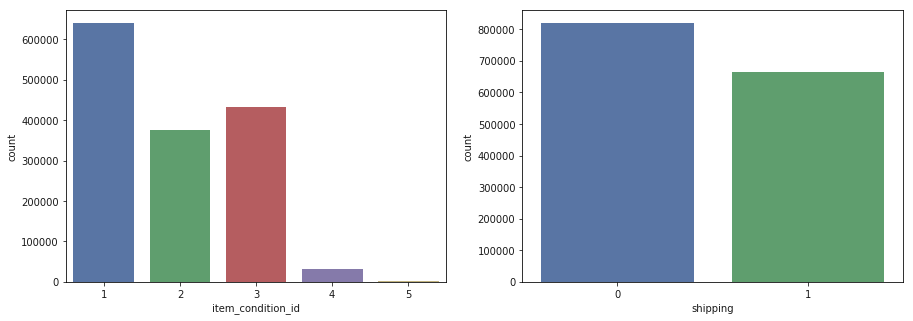

In [5]:
f,ax = plt.subplots(1,2, figsize=(15,5))
sns.set(color_codes=True)
sns.countplot(x="item_condition_id", data=train, ax=ax[0])
# shipping
sns.countplot(x="shipping", data=train, ax=ax[1])

`item_condition_id`, 1状态最好，5状态最差

## 价格字段（目标变量）

In [6]:
train["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

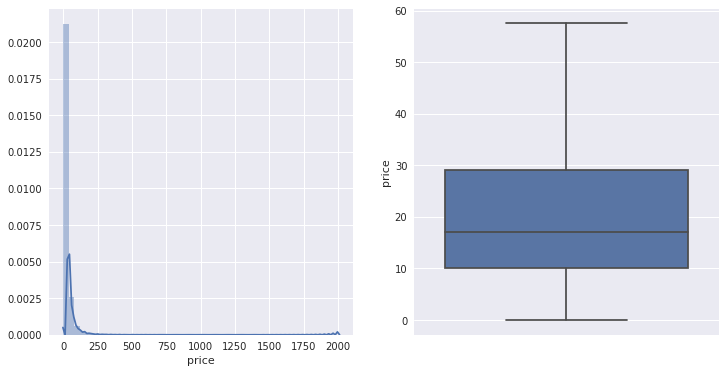

In [7]:
f, ax = plt.subplots(1,2,figsize=(12,6))
sns.distplot(train["price"], ax=ax[0])
sns.boxplot(train["price"], orient="v", showfliers=False, ax=ax[1]) # without outliers

 ## 价格比较
在 `item_condition_id` 和 `shipping` 字段的分组下

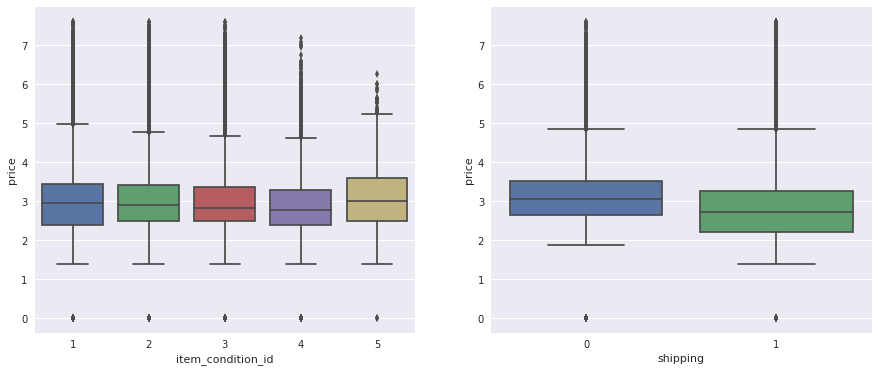

In [8]:
# using log(price)
f, ax = plt.subplots(1,2,figsize=(15,6))

# by item condition
sns.boxplot(x = train.item_condition_id, y = np.log(train.price+1), orient = "v", ax=ax[0])

# by shipping/no shipping
sns.boxplot(x = train.shipping, y = np.log(train.price+1), orient = "v", ax=ax[1])

# 进阶可视化
## 品牌名 与 价格的关系

Text(0.5,1,'Price of Listings with/without Brand')

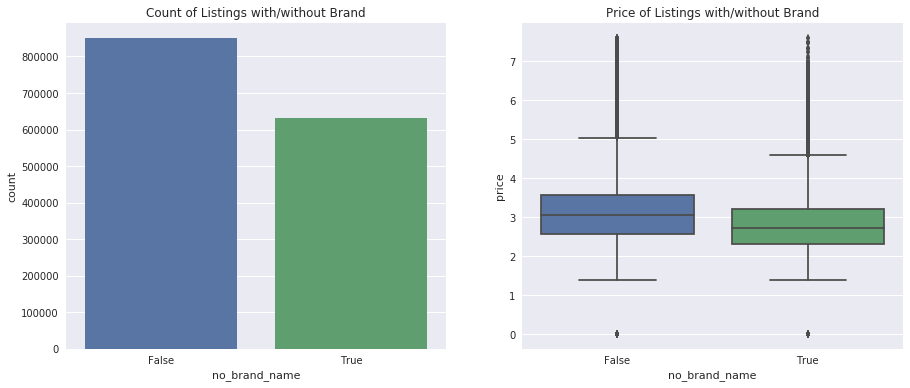

In [9]:
train["no_brand_name"] = train["brand_name"].isnull() 

f, ax = plt.subplots(1,2,figsize=(15,6))
sns.countplot(train["no_brand_name"], ax=ax[0])
ax[0].set_title("Count of Listings with/without Brand")
sns.boxplot(x = train.no_brand_name, y = np.log(train.price+1), ax=ax[1])
ax[1].set_title("Price of Listings with/without Brand")

## 每个品牌的中位数

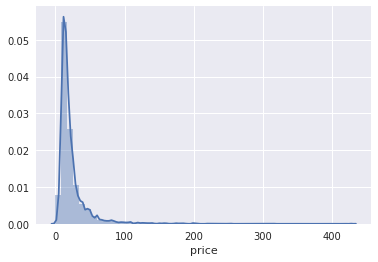

In [15]:
brand_median = train.groupby(["brand_name"], as_index = True).median().price.sort_values(ascending = False)

# plotting the distribution of brand median 
sns.distplot(brand_median)

In [16]:
brand_median[:10]

10 most expensive brands:


brand_name
Demdaco                429.0
Auto Meter             344.0
Proenza Schouler       315.5
Oris                   300.0
Longines               254.0
Blendtec               250.0
Dainese                230.0
Frédérique Constant    224.0
David Yurman           220.0
Vitamix                205.0
Name: price, dtype: float64

### 品牌云图

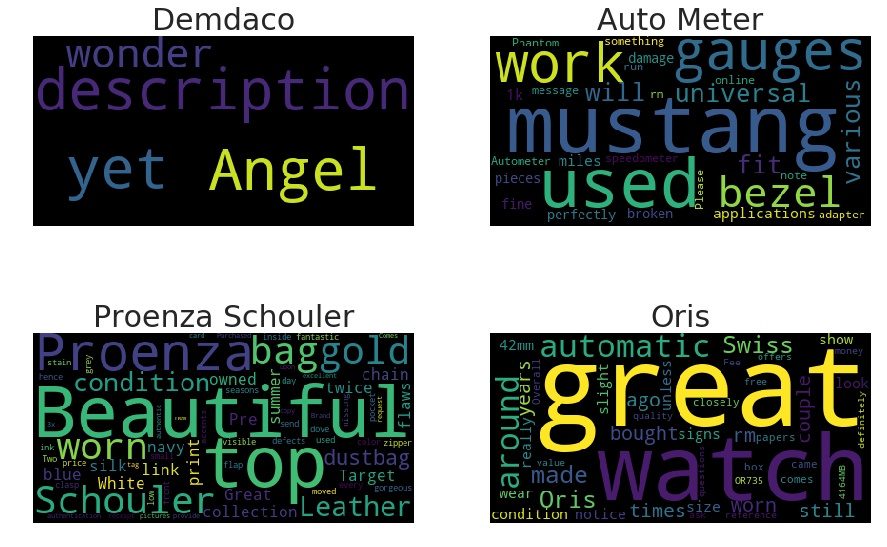

In [17]:
top_brands = ["Demdaco", "Auto Meter", "Proenza Schouler", "Oris"]

fig, ax = plt.subplots(2, 2, figsize = (15, 10))
for brand in range(len(top_brands)):
    b = top_brands[brand]
    wordcloud = WordCloud(max_words = 200
                         ).generate(" ".join(train["item_description"][train["brand_name"] == b].astype(str)))
    ax[int(brand/2)][brand%2].axis("off")
    ax[int(brand/2)][brand%2].imshow(wordcloud)
    ax[int(brand/2)][brand%2].set_title(b, fontsize = 30)
plt.show()

## 按照分类进行统计价格

In [18]:
# extract categories
train["main_cat"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+", expand=False)
train["subcat1"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+", expand=False)
train["subcat2"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)", expand=False)

In [19]:
# excluding NA group
print("Number of Main Categories = " + str(len(pd.unique(train["main_cat"]))-1))
print("Number of Sub Category 1 = " + str(len(pd.unique(train["subcat1"]))-1))
print("Number of Sub Category 2 = " + str(len(pd.unique(train["subcat2"]))-1))

Number of Main Categories = 10
Number of Sub Category 1 = 113
Number of Sub Category 2 = 870


In [20]:
list(pd.unique(train["main_cat"]))

['Men',
 'Electronics',
 'Women',
 'Home',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Beauty',
 'Other',
 'Kids',
 nan,
 'Handmade']

In [21]:
list(pd.unique(train["subcat1"]))

['Tops',
 'Computers & Tablets',
 'Tops & Blouses',
 'Home Décor',
 'Jewelry',
 'Other',
 'Swimwear',
 'Apparel',
 'Collectibles',
 'Makeup',
 'Fragrance',
 'Dresses',
 'Office supplies',
 'Shoes',
 'Gear',
 'Athletic Apparel',
 'Cell Phones & Accessories',
 'Jeans',
 'Underwear',
 'Skin Care',
 'Toys',
 "Women's Handbags",
 'Video Games & Consoles',
 'Coats & Jackets',
 'Pants',
 'Girls (4+)',
 'Antique',
 'Kitchen & Dining',
 'Sweaters',
 'Boys 0-24 Mos',
 'Girls 0-24 Mos',
 'Maternity',
 'Bedding',
 'Exercise',
 'Trading Cards',
 'Boys (4+)',
 'Storage & Organization',
 'Fan Shop',
 'Girls 2T-5T',
 "Men's Accessories",
 'Boys 2T-5T',
 "Women's Accessories",
 'Daily & Travel items',
 nan,
 'Skirts',
 'Hair Care',
 'Pet Supplies',
 'Book',
 'Tools & Accessories',
 'Team Sports',
 'Home Appliances',
 'Accessories',
 'Bags and Purses',
 'Sweats & Hoodies',
 'Shorts',
 'TV, Audio & Surveillance',
 'Outdoors',
 'Bath & Body',
 'Car Seats & Accessories',
 'Toy',
 'Art',
 'Seasonal Décor',


In [22]:
list(pd.unique(train["subcat2"]))

['T-shirts',
 'Components & Parts',
 'Blouse',
 'Home Décor Accents',
 'Necklaces',
 'Other',
 'Two-Piece',
 'Girls',
 'Doll',
 'Face',
 'Women',
 'Above Knee, Mini',
 'School Supplies',
 'Boots',
 'Makeup Sets',
 'Eyes',
 'Backpacks & Carriers',
 'Makeup Palettes',
 'Tank, Cami',
 'Sports Bras',
 'Cell Phones & Smartphones',
 'Chargers & Cradles',
 'T-Shirts',
 'Athletic',
 'Cases, Covers & Skins',
 'Pants, Tights, Leggings',
 'One-Piece',
 'Boot Cut',
 'Bras',
 'Stuffed Animals & Plush',
 'Totes & Shoppers',
 'Shirts & Tops',
 'Consoles',
 'Glass',
 'Vest',
 'Arts & Crafts',
 'Capris, Cropped',
 'Messenger & Crossbody',
 'Shoes',
 'Collectibles',
 'Coffee & Tea Accessories',
 'Brooch',
 'Headsets',
 'Rings',
 'Shorts',
 'Fleece Jacket',
 'Dolls & Accessories',
 'Crewneck',
 'Jackets',
 'Home Fragrance',
 'Accessories',
 'Tops & Blouses',
 'Sheets & Pillowcases',
 'Fitness technology',
 'Dress Up & Pretend Play',
 'Animation',
 'Jewelry Boxes & Organizers',
 'Games',
 'NCAA',
 'Electr

### 不同类别下的价格

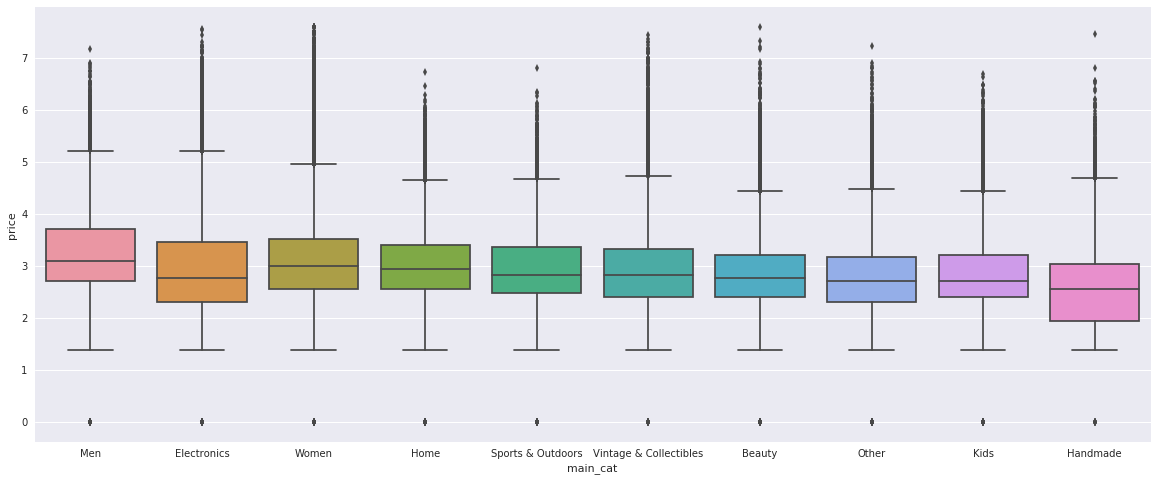

In [23]:
plt.figure(figsize = (20, 8))
sns.boxplot(x = train.main_cat, y = np.log(train.price+1))

### 单个类别内的价格分布

Text(0.5,1,'Sub category 2')

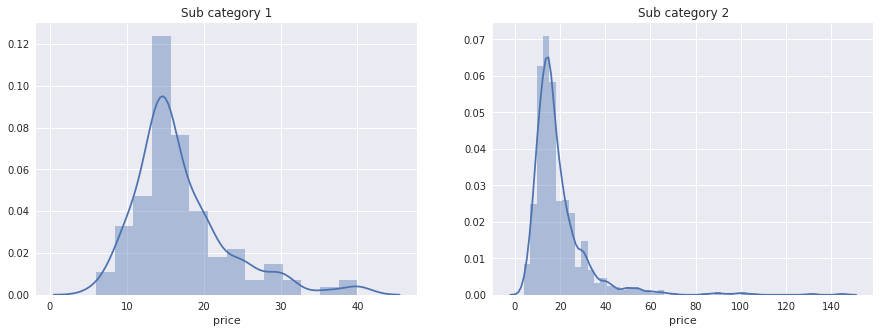

In [24]:
sub1 = train.groupby(["subcat1"], as_index = True).median().price.sort_values(ascending = False)
sub2 = train.groupby(["subcat2"], as_index = True).median().price.sort_values(ascending = False)

f, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(sub1, ax=ax[0])
ax[0].set_title("Sub category 1")
sns.distplot(sub2, ax=ax[1])
ax[1].set_title("Sub category 2")